In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import json, pickle#, gzip
# from gensim.models import Word2Vec
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import classification_report, f1_score

In [2]:
! nvidia-smi

Sat Oct 30 16:37:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 32%   58C    P8    18W / 250W |    630MiB / 11018MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:03:00.0 Off |                  N/A |
| 37%   

In [3]:
post_id_2_text = pickle.load(open("../../data/non-graph/posts_id_2_text.pkl", "rb"))

In [4]:
post2user = pickle.load(open("../../data/non-graph/post_id_2_user_id.pkl", "rb"))
user2posts = pickle.load(open("../../data/non-graph/user_id_posts_idx_list.pkl", "rb"))
for post_id in tqdm(post2user):
    user_id = post2user[post_id]
    post_ids = set(user2posts[user_id])
    post_ids.add(post_id)
    user2posts[user_id] = sorted(list(post_ids))

100%|██████████| 10423/10423 [00:09<00:00, 1077.15it/s]


In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
from transformers import AutoTokenizer, AutoModel
model_name="bert-base-uncased"
# model_name="GroNLP/hateBERT"
# model_name="Hate-speech-CNERG/bert-base-uncased-hatexplain"
tokenizer = AutoTokenizer.from_pretrained(model_name)
print(device)

cuda:0


In [6]:
class Classifier(nn.Module):
    
    def __init__(self, inp_dim, hid_dim, out_logits):
        super(Classifier, self).__init__()

        self.inp_dim = inp_dim
        self.out_dim = out_logits

        self.fc1 = nn.Linear(inp_dim, hid_dim)
        self.fc2 = nn.Linear(hid_dim, out_logits)
    
    def forward(self, x):
        assert x.shape[1] == self.inp_dim

        x = self.fc1(x)
        x = self.fc2(torch.relu(x))
        return torch.log_softmax(x, dim=1)

In [7]:
def get_contrastive_batches(post_ids, y, device, batch_size):
    num_of_batches = y.shape[0] // batch_size + (1 if y.shape[0] % batch_size else 0)
    shuffled_idxs = np.random.permutation(np.arange(y.shape[0]))
    for i in range(num_of_batches):
        batch_idxs = shuffled_idxs[i*batch_size:(i+1)*batch_size]
        X = np.zeros((batch_idxs.shape[0], 15, max_len), dtype=np.float32)
        for dim1, batch_idx in enumerate(batch_idxs):
            post_id = post_ids[batch_idx][:-4]
            positive_sample = post_id
            while positive_sample != post_id:
                positive_sample = np.random.choice(train_class_ids[y[batch_idx]])[:-4]
            batch_post_ids = [post_id, positive_sample]
            negative_classes = [label for label in range(3) if label != y[batch_idx]]
            negative_samples = set()
            while len(negative_samples) != 2:
                negative_samples.add(np.random.choice(train_class_ids[negative_classes[0]])[:-4])
            while len(negative_samples) != 4:
                negative_samples.add(np.random.choice(train_class_ids[negative_classes[1]])[:-4])
            batch_post_ids.extend(list(negative_samples))
            user_id = post2user[int(post_id)]
            positive_sample = post_id
            while positive_sample != post_id:
                positive_sample = str(np.random.choice(user2posts[user_id]))
            batch_post_ids.append(positive_sample)
            negative_user_ids = [userid for userid in user2posts if userid != user_id]
            negative_users = set()
            negative_samples = []
            while len(negative_users) < 8:
                negative_users.add(np.random.choice(negative_user_ids))
            for userid in list(negative_users):
                negative_samples.append(str(np.random.choice(user2posts[userid])))
            batch_post_ids.extend(negative_samples)
            for dim2, post_id in enumerate(batch_post_ids):
                text = post_id_2_text[int(post_id)]
                ids = tokenizer(text, max_length=max_len, padding="max_length", truncation=True)['input_ids']
                X[dim1, dim2] = np.array(ids, dtype=int)
        yield torch.IntTensor(X).to(device),\
                torch.LongTensor(y[batch_idxs]).to(device)

In [8]:
def get_context_batches(post_ids, y, device, batch_size, num=10):
    num_of_batches = y.shape[0] // batch_size + (1 if y.shape[0] % batch_size else 0)
    shuffled_idxs = np.random.permutation(np.arange(y.shape[0]))
    for i in range(num_of_batches):
        batch_idxs = shuffled_idxs[i*batch_size:(i+1)*batch_size]
        X = np.zeros((batch_idxs.shape[0], num, max_len), dtype=np.float32)
        for dim1, batch_idx in enumerate(batch_idxs):
            post_id = post_ids[batch_idx][:-4]
            batch_post_ids = [post_id]
            user_id = post2user[int(post_id)]
            for _ in range(num-1):
                batch_post_ids.append(str(np.random.choice(user2posts[user_id])))
            for dim2, post_id in enumerate(batch_post_ids):
                text = post_id_2_text[int(post_id)]
                ids = tokenizer(text, max_length=max_len, padding="max_length", truncation=True)['input_ids']
                X[dim1, dim2] = np.array(ids, dtype=int)
        yield torch.IntTensor(X).to(device),\
                torch.LongTensor(y[batch_idxs]).to(device)

In [9]:
def get_batches(post_ids, y, device, batch_size):
    num_of_batches = y.shape[0] // batch_size + (1 if y.shape[0] % batch_size else 0)
    shuffled_idxs = np.random.permutation(np.arange(y.shape[0]))
    for i in range(num_of_batches):
        batch_idxs = shuffled_idxs[i*batch_size:(i+1)*batch_size]
        X = np.zeros((batch_idxs.shape[0], 1, max_len), dtype=np.float32)
        for dim1, batch_idx in enumerate(batch_idxs):
            post_id = int(post_ids[batch_idx][:-4])
            batch_post_ids = [post_id]
            for dim2, post_id in enumerate(batch_post_ids):
                text = post_id_2_text[post_id]
                ids = tokenizer(text, max_length=max_len, padding="max_length", truncation=True)['input_ids']
                X[dim1, dim2] = np.array(ids, dtype=int)
        yield torch.IntTensor(X.squeeze()).to(device),\
                torch.LongTensor(y[batch_idxs]).to(device)

In [10]:
def contrastive_train(epoch_num, data, labels, device, optimizers, criterion, enc, clf, batch_size=32, verbose=False):
    print("Training | Epoch:", epoch_num)
    enc.train()
    # clf.train()
    losses = []
    for i, batch in enumerate(tqdm(get_contrastive_batches(data, labels, device, batch_size),
                                    total=data.shape[0]//batch_size+(1 if data.shape[0]%batch_size else 0))):
        # given actual post
        out = enc(batch[0][:,0])['pooler_output']
        # given class level contrastive samples
        similarities1 = torch.zeros(batch[0].shape[0], 5).to(device)
        for j in range(1, 6):
            with torch.no_grad():
                out1 = enc(batch[0][:,j])['pooler_output']
            similarities1[:, j-1] = torch.mul(out, out1).sum(dim=1)
        loss1 = criterion(torch.log_softmax(similarities1, dim=1), torch.zeros(batch[0].shape[0], dtype=int).to(device))
        # given user level contrastive samples
        similarities2 = torch.zeros(batch[0].shape[0], 9).to(device)
        for j in range(6, 15):
            with torch.no_grad():
                out2 = enc(batch[0][:,j])['pooler_output']
            similarities2[:, j-6] = torch.mul(out, out2).sum(dim=1)
        loss2 = criterion(torch.log_softmax(similarities2, dim=1), torch.zeros(batch[0].shape[0], dtype=int).to(device))
        batch_loss = loss1 + loss2
        for optimizer in optimizers:
            optimizer.zero_grad()
        batch_loss.backward()
        for optimizer in reversed(optimizers):
            optimizer.step()
        losses.append(batch_loss.item())
        if verbose:
            print("Epoch:", epoch_num, "| Iter:", i+1, "| Loss1:", round(loss1.item(), 4),\
                  "| Loss2:", round(loss2.item(), 4), "| Total Loss:", round(batch_loss.item(), 4))
    enc.eval()
    clf.eval()
    return losses

In [11]:
def label_finetune(epoch_num, data, labels, device, optimizers, criterion, enc, clf, batch_size=32, verbose=False):
    print("Training | Epoch:", epoch_num)
    enc.train()
    clf.train()
    losses = []
    for i, batch in enumerate(tqdm(get_batches(data, labels, device, batch_size),
                                    total=data.shape[0]//batch_size+(1 if data.shape[0]%batch_size else 0))):
        inp = enc(batch[0])['pooler_output']
        out = clf(inp)
        loss = criterion(out, batch[1])
        for optimizer in optimizers:
            optimizer.zero_grad()
        loss.backward()
        for optimizer in reversed(optimizers):
            optimizer.step()
        losses.append(loss.item())
        if verbose:
            print("Epoch:", epoch_num, "| Iter:", i+1, "| Loss:", round(loss.item(), 4))
    enc.eval()
    clf.eval()
    return losses

In [12]:
def context_finetune(epoch_num, data, labels, device, optimizers, criterion, enc, clf, batch_size=32, verbose=False):
    print("Training | Epoch:", epoch_num)
    enc.train()
    clf.train()
    losses = []
    for i, batch in enumerate(tqdm(get_context_batches(data, labels, device, batch_size),
                                    total=data.shape[0]//batch_size+(1 if data.shape[0]%batch_size else 0))):
        outs = []
        for j in range(10):
            if j > 0:
                with torch.no_grad():
                    outs.append(clf(enc(batch[0][:,j])['pooler_output']))
                continue
            outs.append(clf(enc(batch[0][:,j])['pooler_output']))
        loss = criterion(outs[0], batch[1])
        for out in outs[1:]:
            loss += criterion(out, batch[1])
        for optimizer in optimizers:
            optimizer.zero_grad()
        loss.backward()
        for optimizer in reversed(optimizers):
            optimizer.step()
        losses.append(loss.item())
        if verbose:
            print("Epoch:", epoch_num, "| Iter:", i+1, "| Loss:", round(loss.item(), 4))
    enc.eval()
    clf.eval()
    return losses

In [13]:
def evaluate(epoch_num, data, labels, device, enc, clf, batch_size=64):
    print("Evaluating | Epoch:", epoch_num)
    enc.eval()
    clf.eval()
    y_preds = []
    y_tests = []
    for batch in tqdm(get_batches(data, labels, device, batch_size),\
                                    total=data.shape[0]//batch_size+(1 if data.shape[0]%batch_size else 0)):
        with torch.no_grad():
            inp = enc(batch[0])['pooler_output']
            out = clf(inp)
        for y in batch[1].cpu().numpy():
            y_tests.append(y)
        for y in out.argmax(dim=1).cpu().numpy():
            y_preds.append(y)
    print(classification_report(y_tests, y_preds))
    print(round(f1_score(y_tests, y_preds, average="macro"), 4), round(f1_score(y_tests, y_preds, average="micro"), 4))

In [14]:
def get_ids_and_labels(split):
    ids = [i for i in pid[split] if 'gab' in i]
    labels = [label_dict[Counter([j["label"] for j in data[i]["annotators"]]).most_common(1)[0][0]] for i in pid[split] if 'gab' in i]
    return np.array(ids), np.array(labels)

In [15]:
data_path = '../../data/commons/dataset.json'
pid_path = '../../data/commons/post_id_divisions.json'

with open(pid_path) as f:
    pid = json.load(f)
with open(data_path) as f:
    data = json.load(f)

label_dict = {'normal': 0, 'offensive': 1, 'hatespeech': 2}

train_ids, train_labels = get_ids_and_labels("train")
val_ids, val_labels = get_ids_and_labels("val")
test_ids, test_labels = get_ids_and_labels("test")

In [16]:
train_class_ids = []
train_class_ids.append(sorted(list(train_ids[train_labels==0])))
train_class_ids.append(sorted(list(train_ids[train_labels==1])))
train_class_ids.append(sorted(list(train_ids[train_labels==2])))

In [21]:
# max_len = 128
# encoder = AutoModel.from_pretrained('../../../../mlm/checkpoint-201500').to(device)
# classifier = Classifier(768, 128, 3).to(device)
optimizer1 = optim.Adam(encoder.parameters(), lr=1e-6)
optimizer2 = optim.Adam(classifier.parameters(), lr=1e-5)
optimizers = [optimizer1, optimizer2]
# criterion = nn.NLLLoss()

# aux_losses = []
# for i in range(3):
#     aux_losses.extend(contrastive_train(i+1, train_ids, train_labels, device, optimizers, criterion, encoder, classifier, 32))
# plt.plot(aux_losses)
# plt.show()
# torch.save(encoder.state_dict(), "encoder_hxbert_user_class_NLL.pth")

encoder.load_state_dict(torch.load("encoder_hxbert_user_class_NLL.pth"))
# encoder.load_state_dict(torch.load("encoder_hxbert_user_class.pth"))
# classifier.load_state_dict(torch.load("classifier_hxbert_user_class.pth"))

<All keys matched successfully>

Training | Epoch: 1


100%|██████████| 262/262 [05:08<00:00,  1.18s/it]


Evaluating | Epoch: 1


100%|██████████| 33/33 [00:02<00:00, 11.19it/s]


              precision    recall  f1-score   support

           0       0.62      0.59      0.61       216
           1       0.56      0.52      0.54       305
           2       0.79      0.84      0.81       515

    accuracy                           0.69      1036
   macro avg       0.66      0.65      0.65      1036
weighted avg       0.69      0.69      0.69      1036

0.6522 0.6921
Training | Epoch: 2


100%|██████████| 262/262 [05:08<00:00,  1.18s/it]


Evaluating | Epoch: 2


100%|██████████| 33/33 [00:02<00:00, 11.31it/s]


              precision    recall  f1-score   support

           0       0.68      0.54      0.60       216
           1       0.57      0.51      0.54       305
           2       0.75      0.87      0.81       515

    accuracy                           0.69      1036
   macro avg       0.67      0.64      0.65      1036
weighted avg       0.68      0.69      0.69      1036

0.6488 0.694
Training | Epoch: 3


100%|██████████| 262/262 [05:07<00:00,  1.17s/it]


Evaluating | Epoch: 3


100%|██████████| 33/33 [00:02<00:00, 11.24it/s]


              precision    recall  f1-score   support

           0       0.67      0.57      0.62       216
           1       0.57      0.50      0.53       305
           2       0.76      0.87      0.81       515

    accuracy                           0.70      1036
   macro avg       0.67      0.65      0.65      1036
weighted avg       0.69      0.70      0.69      1036

0.6539 0.6969


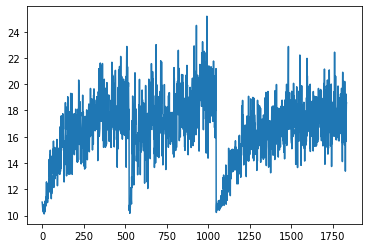

In [22]:
# losses = []
for i in range(3):
    losses.extend(context_finetune(i+1, train_ids, train_labels, device, optimizers, criterion, encoder, classifier, 32))
    evaluate(i+1, test_ids, test_labels, device, encoder, classifier, batch_size=32)
plt.plot(losses)
plt.show()

In [ ]:
# torch.save(encoder.state_dict(), "encoder_hatebert_user_class.pth")
# torch.save(classifier.state_dict(), "classifier_hatebert_user_class.pth")